# Notebook 4 – Clustering + PCA (Bank Marketing)

**Objetivo de la sesión:**  
Aprender a aplicar **clustering (K-Means)** y **PCA** sobre datos reales de clientes bancarios, para:
- Detectar grupos de clientes con perfiles similares.
- Reducir dimensionalidad y visualizar clusters en 2D.
- Interpretar qué representa cada cluster y cómo podría usarse en productos de IA para SISRED.

Dataset: **Bank Marketing** (`bank_marketing.csv`)  
Target original: `deposit` (sí/no).  
👉 En este notebook trabajaremos de forma **no supervisada** (sin usar `deposit` para entrenar el modelo), pero la utilizaremos **solo para interpretar** los clusters.


In [2]:
# Celda 1 – Importar librerías

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


## 1. Carga del dataset

En esta sección:

- Cargamos el CSV original (sin preprocesar).
- Revisamos la estructura general del dataset.
- Identificamos qué columnas podrían ser útiles para clustering.

> Ajustar la ruta del archivo según el entorno local.


In [3]:
# Celda 2 – Cargar datos crudos

# Ajusta la ruta si es necesario
df = pd.read_csv("bank.csv")

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Celda 3 – Inspección rápida

print("Dimensiones del dataset:", df.shape)
print("\nInformación general:\n")
df.info()


Dimensiones del dataset: (11162, 17)

Información general:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
# Celda 4 – Estadísticas descriptivas básicas

df.describe(include="all").transpose().head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,11162.0,NaN,NaN,NaN,41.231948,11.913369,18.0,32.0,39.0,49.0,95.0
job,11162,12,management,2566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,11162,3,married,6351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,11162,4,secondary,5476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,11162,2,no,10994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,11162.0,NaN,NaN,NaN,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.0,81204.0
housing,11162,2,no,5881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,11162,2,no,9702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,11162,3,cellular,8042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,11162.0,NaN,NaN,NaN,15.658036,8.42074,1.0,8.0,15.0,22.0,31.0


### Comentario

Observaciones:

- `age`, `balance`, `duration`, `campaign`, `pdays`, `previous` son **numéricas**.
- Varias columnas como `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `poutcome`, `deposit` son **categóricas**.
- Para simplificar el ejercicio de clustering en 65 minutos y hacer foco en las ideas:
  - Usaremos primero un **subconjunto de variables numéricas**.
  - Luego interpretaremos los clusters usando `deposit` y algún par de variables categóricas.

En un entorno productivo se podrían incluir variables categóricas mediante one-hot encoding, pero eso lo dejamos fuera para esta sesión.


## 2. Selección de variables para clustering

Usaremos como base las siguientes variables numéricas:

- `age`: edad del cliente.
- `balance`: saldo medio anual en la cuenta.
- `duration`: duración de la última llamada de campaña (segundos).
- `campaign`: número de contactos realizados durante esta campaña.
- `pdays`: días desde el último contacto en una campaña anterior (−1 si no ha sido contactado).
- `previous`: número de contactos previos.

No utilizaremos `deposit` para el entrenamiento, pero la conservaremos para análisis posterior.


In [6]:
# Celda 5 – Selección de columnas numéricas para clustering

features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

X = df[features].copy()

X.head()


,age,balance,duration,campaign,pdays,previous
0,59,2343,1042,1,-1,0
1,56,45,1467,1,-1,0
2,41,1270,1389,1,-1,0
3,55,2476,579,1,-1,0
4,54,184,673,2,-1,0


In [7]:
# Celda 6 – Revisión de valores faltantes en las variables seleccionadas

X.isnull().sum()


age         0
balance     0
duration    0
campaign    0
pdays       0
previous    0
dtype: int64

Si existen valores faltantes, decidimos una estrategia simple (por tiempo):

- Opción 1: eliminar filas con NA en estas columnas.
- Opción 2: imputar con mediana.

En este notebook usaremos una estrategia sencilla: **imputar con la mediana**.


In [9]:
# Celda 7 – Imputación simple con mediana

X_imputed = X.fillna(X.median(numeric_only=True))

X_imputed.isnull().sum()



age         0
balance     0
duration    0
campaign    0
pdays       0
previous    0
dtype: int64

## 3. Estandarización de variables

K-Means es sensible a la escala de las variables.  
Por ejemplo, `balance` puede estar en miles, mientras que `campaign` puede ser un número pequeño.

Por eso usamos `StandardScaler`:

$$z = \frac{x - \mu}{\sigma}$$

Así, todas las variables tendrán media 0 y desviación estándar 1 (aprox.).


In [10]:
# Celda 8 – Escalado de las variables

scaler = Z
X_scaled = scaler.fit_transform(X_imputed)

print("Shape de X_scaled:", X_scaled.shape)


Shape de X_scaled: (11162, 6)


## 4. Elección del número de clusters (K)

Usaremos el método del **codo (elbow)**:

- Entrenamos K-Means para K en {2, 3, 4, 5, 6}.
- Para cada K, calculamos el **inertia_** (suma de distancias cuadráticas intra-cluster).
- Buscamos un punto donde la mejora empiece a ser marginal (codo).

Esto nos da una guía razonable en el tiempo disponible.


In [11]:
# Celda 9 – Búsqueda de K usando método del codo

inertias = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

inertias


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\felip\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\felip\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\felip\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\felip\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\felip\anaconda3\Lib\site-packages\joblib\externals\

[54310.59917767724,
 47715.24063465616,
 42067.45206524004,
 36551.151822636035,
 31676.227426082412]

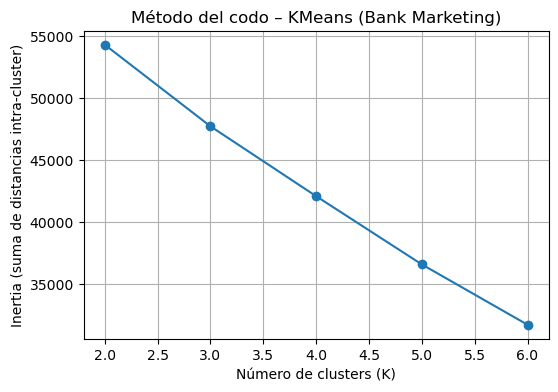

In [12]:
# Celda 10 – Gráfico del codo

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inertia (suma de distancias intra-cluster)")
plt.title("Método del codo – KMeans (Bank Marketing)")
plt.grid(True)
plt.show()


### Interpretación rápida

- Busquen en el gráfico el valor de K donde la **curva empieza a “doblarse”** (el codo).
- Ese K ofrece un balance entre:
  - buena compactación intra-cluster,
  - y complejidad del modelo (número de clusters).

Para efectos de esta sesión, seleccionaremos un K razonable (por ejemplo, **K = 3** o **K = 4** según lo que se observe en el gráfico).

> Para el resto del notebook, asumiremos **K = 3**. Si el grupo decide K distinto, solo cambien la variable `best_k`.


In [13]:
# Celda 11 – Entrenar modelo final de KMeans con K elegido

best_k = 3  # Cambiar si el grupo decide otro valor

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Agregamos los labels al dataframe original
df["cluster"] = clusters

df[features + ["cluster"]].head()


,age,balance,duration,campaign,pdays,previous,cluster
0,59,2343,1042,1,-1,0,0
1,56,45,1467,1,-1,0,0
2,41,1270,1389,1,-1,0,0
3,55,2476,579,1,-1,0,1
4,54,184,673,2,-1,0,0


## 5. Evaluación básica del clustering

Dos medidas simples:

1. **Inertia** del modelo final (suma de distancias intra-cluster).
2. **Silhouette score**: medida de qué tan bien separados están los clusters (entre -1 y 1).


In [14]:
# Celda 12 – Métricas de calidad de clustering

final_inertia = kmeans_final.inertia_
sil_score = silhouette_score(X_scaled, clusters)

print(f"Inertia (K={best_k}): {final_inertia:.2f}")
print(f"Silhouette score (K={best_k}): {sil_score:.3f}")



Inertia (K=3): 47715.24
Silhouette score (K=3): 0.270


**Interpretación:**

- Una menor **inertia** indica clusters más compactos (menor distancia intra-cluster).
- Un **silhouette score** cercano a 1 indica buena separación entre clusters; valores cercanos a 0 implican clusters solapados.

👉 No se trata de memorizar valores “buenos” o “malos”, sino de comparar configuraciones y entender si los clusters tienen sentido de negocio.


## 6. PCA: Reducción a 2 dimensiones

Objetivo:

- Reducir las 6 variables numéricas seleccionadas a **2 componentes principales**.
- Usar estas 2 dimensiones para **visualizar los clusters en un plano 2D**.

El PCA encuentra combinaciones lineales de las variables originales que explican la mayor varianza posible.


In [15]:
# Celda 13 – Aplicar PCA a los datos escalados

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.25571781 0.18563967]
Varianza explicada acumulada: 0.4413574816299335


In [16]:
# Celda 14 – Crear DataFrame con componentes principales y clusters

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)
pca_df["cluster"] = clusters

pca_df.head()


,PC1,PC2,cluster
0,-0.484576,1.690722,0
1,-0.612879,1.276227,0
2,-0.632207,0.640690,0
3,-0.428663,1.219236,1
4,-0.571678,0.689849,0


## 7. Visualización 2D de los clusters

Usaremos las dos componentes principales (PC1, PC2) para:

- Graficar cada punto como un cliente.
- Colorear según el cluster asignado por KMeans.


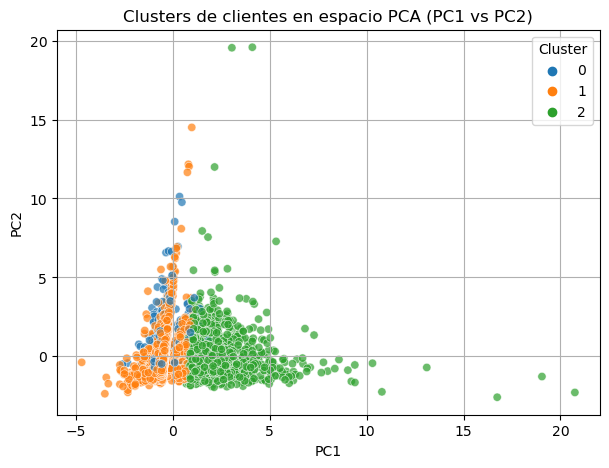

In [17]:
# Celda 15 – Gráfico 2D de clusters en espacio PCA

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("Clusters de clientes en espacio PCA (PC1 vs PC2)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


**Discusión guiada:**

- ¿Se observan grupos relativamente bien separados?
- ¿Hay clusters que se mezclan?
- ¿Parece haber algún cluster muy pequeño o muy grande?

Recuerden que PCA es solo una proyección 2D; algunos solapamientos en el gráfico pueden ser aceptables.


## 8. Interpretación de clusters

Ahora, vamos a intentar responder:

> “¿Qué representa cada cluster, en términos de comportamiento del cliente?”

Para ello:

- Calculamos promedios por cluster de las variables numéricas usadas para el clustering.
- Miramos la proporción de clientes que contrataron el depósito (`deposit == "yes"`) en cada cluster.


In [18]:
# Celda 16 – Promedio de variables numéricas por cluster

cluster_profile_numeric = df.groupby("cluster")[features].mean().round(2)
cluster_profile_numeric


,age,balance,duration,campaign,pdays,previous
cluster,,,,,,
0,40.90,1679.59,969.19,2.58,8.36,0.14
1,41.10,1398.97,227.17,2.67,4.67,0.10
2,41.91,1807.64,327.54,1.93,232.87,3.70


In [19]:
# Celda 17 – Tasa de conversión de depósito por cluster

# Si deposit está codificada como 'yes'/'no'
deposit_rate = (
    df.groupby("cluster")["deposit"]
    .apply(lambda x: (x == "yes").mean())
    .rename("deposit_yes_rate")
    .round(3)
)

deposit_rate


cluster
0    0.853
1    0.318
2    0.647
Name: deposit_yes_rate, dtype: float64

In [20]:
# Celda 18 – Resumen combinado: perfil + tasa de depósito

cluster_summary = cluster_profile_numeric.copy()
cluster_summary["deposit_yes_rate"] = deposit_rate

cluster_summary


,age,balance,duration,campaign,pdays,previous,deposit_yes_rate
cluster,,,,,,,
0,40.90,1679.59,969.19,2.58,8.36,0.14,0.853
1,41.10,1398.97,227.17,2.67,4.67,0.10,0.318
2,41.91,1807.64,327.54,1.93,232.87,3.70,0.647


### Interpretación orientativa

Preguntas para cada cluster:

- ¿Tienen mayores edades (`age`)?
- ¿Tienen saldos (`balance`) más altos o bajos?
- ¿Han recibido más llamadas (`campaign`)?
- ¿Tienen mayor probabilidad de contratar el depósito (`deposit_yes_rate`)?

**Ejercicio para el grupo (mini-desafío):**

1. Escriban una breve descripción de cada cluster, por ejemplo:
   - *Cluster 0: clientes de mayor edad y saldo medio alto, con buena tasa de conversión.*
   - *Cluster 1: clientes más jóvenes, menor saldo, baja tasa de conversión, etc.*
2. Discutan qué tipo de **estrategia de campaña** se podría diseñar para cada cluster:
   - ¿A quién vale la pena llamar de nuevo?
   - ¿A quién solo enviar correos?
   - ¿Dónde podría tener sentido aplicar modelos más complejos (ej. ML supervisado)?


## 9. Mini-desafío (para SISRED)

En grupos pequeños:

1. Imaginen que en SISRED tienen **usuarios o entidades** en lugar de clientes bancarios.
2. Básense en este ejercicio para responder:
   - ¿Qué tipo de clusters serían interesantes de encontrar en SISRED?
   - ¿Qué variables reales de SISRED se podrían usar?
   - ¿Qué producto de IA podrían construir usando estos clusters?  
     (ej.: priorización de tickets, segmentación de sistemas, alertas tempranas, etc.)

Anoten sus conclusiones para compartirlas en la puesta en común final.


## 10. Conclusión – ¿Qué aprendimos hoy?

En este notebook trabajamos con un enfoque **no supervisado**, lo que significa:

- **No usamos la variable objetivo `deposit` para entrenar el modelo.**
- El algoritmo **no sabe** cuál es el “resultado correcto”.
- Su tarea es **descubrir patrones y grupos naturales** en los datos sin una etiqueta previa.

Este enfoque se diferencia de los modelos **supervisados** (Logistic Regression, Decision Tree, Random Forest) vistos ayer, donde:

- Sí existe una variable objetivo (`deposit`, incidente crítico / no crítico, etc.).
- El modelo aprende una relación *X → y*.
- Podemos medir exactitud porque sabemos el “resultado correcto”.

### ¿Qué aporta el clustering?

- Ayuda a **descubrir segmentos** en poblaciones grandes (clientes, sistemas, usuarios de SISRED).
- Permite hacer **análisis exploratorio profundo** sin necesidad de etiquetas.
- Reduce complejidad mediante **PCA**, facilitando la visualización y el entendimiento.
- Sienta la base para:
  - segmentación,
  - priorización,
  - agrupación de entidades similares,
  - bases para sistemas de recomendación o alertas.

### ¿Qué representaron nuestros clusters?

Revisamos:

- Perfiles numéricos promedio por cluster.
- La tasa real de `deposit` dentro de cada cluster.
- Qué características diferencian a cada grupo (mayor edad, mayor saldo, más contacto, etc.).

Esto permite:

- Interpretar los clusters como **tipos de clientes**.
- Relacionarlos con comportamientos reales (ej.: quién tiende más a contratar un depósito).
- Tomar decisiones más informadas sin necesidad de supervisión explícita.

### ¿Y cómo se conecta con SISRED?

Este mismo proceso puede usarse en:

- Agrupación de sistemas con patrones de error similares.
- Segmentación de usuarios internos según comportamiento.
- Detección de grupos de incidentes con características comunes.
- Descubrimiento de patrones sin depender de datos etiquetados.

---

En resumen:

**Modelos supervisados** → predicen *algo específico* (clasificación, regresión).  
**Clustering + PCA (no supervisado)** → descubren *estructura oculta* en los datos.

Ambos enfoques se complementan y son fundamentales para construir sistemas de IA robustos, como los que SISRED quiere desarrollar.


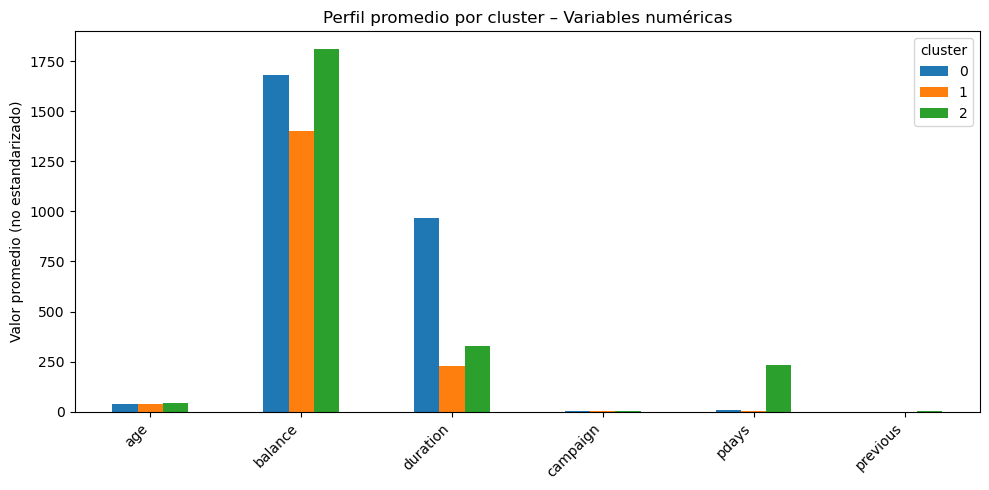

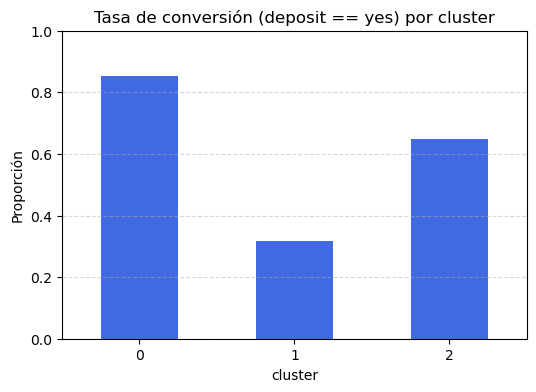

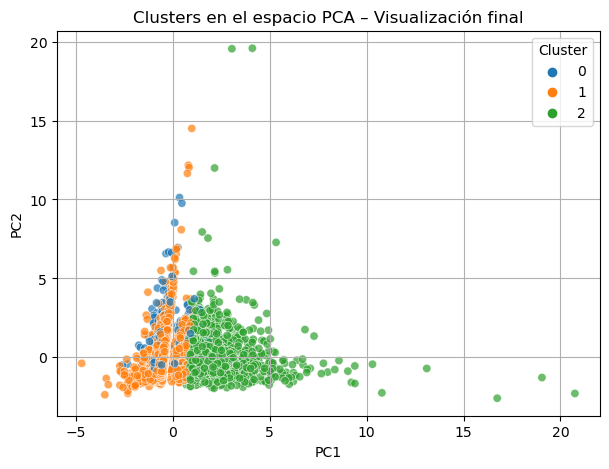

In [21]:
# Celda Final – Gráficos de resumen de resultados

# 1) Perfil promedio por cluster (variables numéricas)
fig, ax = plt.subplots(figsize=(10, 5))
cluster_profile_numeric.T.plot(kind="bar", ax=ax)
plt.title("Perfil promedio por cluster – Variables numéricas")
plt.ylabel("Valor promedio (no estandarizado)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 2) Tasa de 'deposit == yes' por cluster
fig, ax = plt.subplots(figsize=(6, 4))
deposit_rate.plot(kind="bar", color="royalblue", ax=ax)
plt.title("Tasa de conversión (deposit == yes) por cluster")
plt.ylabel("Proporción")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()


# 3) Gráfico PCA final (PC1 vs PC2)
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("Clusters en el espacio PCA – Visualización final")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


## 📊 Interpretación Final de los Resultados del Clustering

En esta sección analizamos los 3 gráficos generados al final del Notebook 4.  
El objetivo es entender **qué representa cada cluster**, cómo se comportan sus variables y si existe algún patrón útil para decisiones de negocio o para un sistema tipo SISRED.

---

### 🔵 1. Perfil promedio por cluster (variables numéricas)

Este gráfico compara los valores promedio de las principales variables numéricas (`age`, `balance`, `duration`, `campaign`, `pdays`, `previous`) para cada cluster.

**Interpretación clave:**

- **Cluster 0**  
  - Balance alto  
  - Duración de llamada muy alta  
  - Mayor edad  
  → Perfil: *clientes maduros y con relación financiera fuerte; muy comprometidos con la campaña.*

- **Cluster 1**  
  - Menores balances  
  - Llamadas cortas  
  - Edad media  
  → Perfil: *clientes más transaccionales, baja respuesta, poco involucrados.*

- **Cluster 2**  
  - El balance más alto de todos  
  - Contactos previos (`pdays`) muy elevados  
  → Perfil: *clientes con historial previo de campañas, potencialmente sensibles a nuevas ofertas.*

Este gráfico revela **qué caracteriza numéricamente a cada grupo** y facilita entender por qué podrían comportarse distinto entre sí.

---

### 🟦 2. Tasa de conversión (`deposit == yes`) por cluster

Este gráfico muestra la proporción real de clientes que contrataron un depósito dentro de cada cluster.

Resultados observados:

- **Cluster 0** → ~0.85  
  **Altísima conversión.**
- **Cluster 2** → ~0.65  
  Conversión media/alta.
- **Cluster 1** → ~0.32  
  Conversión muy baja.

**Conclusión clave:**  
Los clusters *no solo son distintos en comportamiento numérico*, sino que también reflejan **diferencias reales en probabilidad de acción del cliente**.

Esto valida que el clustering **capturó segmentos reales** y no solo ruido.

---

### 🟢 3. Visualización PCA (PC1 vs PC2)

El gráfico PCA proyecta los clientes en un plano 2D, usando las dos componentes principales que capturan la mayor parte de la varianza.

Observaciones:

- Los tres clusters se distribuyen en regiones claramente diferenciadas.
- El **cluster 2** ocupa una zona amplia y dispersa → alta variabilidad interna.
- El **cluster 1** aparece más compacto y concentrado → perfil homogéneo.
- El **cluster 0** se solapa parcialmente con cluster 1, pero mantiene características numéricas propias.

**Interpretación clave:**  
PCA confirma que el modelo K-Means **descubrió estructura real** en los datos.  
Aunque no es perfecto (como todo método no supervisado), los grupos son suficientemente distintos como para justificar análisis o acciones específicas.

---

### 🎯 Conclusión general

- Los clusters representan **grupos con comportamientos financieros diferentes**.  
- Estos grupos muestran **diferencias reales en la probabilidad de contratar un depósito**, lo que valida el clustering.  
- Esta metodología puede trasladarse fácilmente a SISRED para:
  - segmentar usuarios,
  - agrupar sistemas con comportamientos similares,
  - identificar patrones sin necesidad de etiquetas,
  - mejorar priorización y análisis operativo.

El resultado final es una segmentación clara, interpretable y accionable: justo lo que se espera de un análisis no supervisado bien hecho.
